In [46]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models

In [47]:
##Hardware
import torch
if torch.cuda.is_available() == True:
    device = 'cuda'
    templist = [1,2,3]
    templist = torch.FloatTensor(templist).to(device)
    print("Cuda torch working : ",end="")
    print(templist.is_cuda)
    print("current device no. : ",end="")
    print(torch.cuda.current_device())
    print("GPU device count : ",end="")
    print(torch.cuda.device_count())
    print("GPU name : ",end="")
    print(torch.cuda.get_device_name(0))
    print("device : ",device)
    ! nvidia-smi
elif torch.backends.mps.is_available() == True:
    print("Apple device detected\nActivating Apple Silicon GPU")
    device = torch.device("mps")
else:
    print("cant use gpu , activating cpu")
    device = 'cpu'

In [48]:
import torchvision.transforms as transfroms
import torchvision

batch = 100
core = 8
change_to_244 = transfroms.Compose(
    [transfroms.Resize((244,244)),
    transfroms.ToTensor(),
    transfroms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)

trainset = torchvision.datasets.CIFAR100(root='./CIFAR100',
                                        train=True,
                                        transform=change_to_244,
                                        download=True)
trainloader = torch.utils.data.DataLoader(trainset,
                                            batch_size = batch,
                                            shuffle = True,
                                            num_workers = core)
testset = torchvision.datasets.CIFAR100(root='./CIFAR100',
                                        train=True,
                                        transform=change_to_244,
                                        download=True)
testloader = torch.utils.data.DataLoader(testset,
                                        batch_size = batch,
                                        shuffle = True,
                                        num_workers = core)

Files already downloaded and verified
Files already downloaded and verified


In [49]:
trainset

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./CIFAR100
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(244, 244), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [50]:
vgg16model = torchvision.models.vgg16(pretrained=True)
vgg16model.to(device)

vgg16model.classifier[6].out_features = 100

for param in vgg16model.features.parameters():
    param.requires_grad = False

c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
vgg16model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16model.classifier.parameters(), lr=0.001, momentum=0.9)

In [53]:
def train_2(model,loader):
    model.eval()
    for data in loader:
        img , label = data[0].to(device) , data[1].to(device)
        predict_label = model(img)
        loss = criterion(predict_label,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item()

In [54]:
def eval(model,test_loader):
    model.eval()
    acc = 0
    for data in test_loader:
        img , label = data[0].to(device) , data[1].to(device)
        predict_label_list = model(img)
        loss = criterion(predict_label_list,label)
        _,predict_label = torch.max(predict_label_list,1)#torchmax with dim = 1 returns values and index
        #the shape of predic is 10,1000 why??? i dont understand but the index is allways between 1 and 100

        acc += (label == predict_label).float().sum()/len(label)
    return (acc*100/batch)

In [55]:
#eval(vgg16model,testloader)

In [56]:
"""
nb_epoch = 5
for epoch in range(nb_epoch):
    print(train(vgg16model,trainloader),end=' ')
    print(eval(vgg16model,testloader))"""

"\nnb_epoch = 5\nfor epoch in range(nb_epoch):\n    print(train(vgg16model,trainloader),end=' ')\n    print(eval(vgg16model,testloader))"

In [57]:
# training function
def train(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for data in (train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)

    #print('Train Loss: %.4f'%train_loss)
    
    return train_loss, train_accuracy

In [58]:
#validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for data in (test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

In [59]:
import time
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(10):
    train_epoch_loss, train_epoch_accuracy = train(vgg16model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(vgg16model, testloader)
    print("Train Loss : %f/  Train Acc : %.2f/  Val Loss : %f/  Val Acc : %.2f"%(train_epoch_loss,train_epoch_accuracy,val_epoch_loss,val_epoch_accuracy))
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    #print("Train Acc : %f"%train_accuracy,"Val Acc : %f"%val_accuracy)
    
end = time.time()

print(int((end-start)//60), 'minutes', int((end-start)%60), 'seconds')

Train Loss : 0.042460/  Train Acc : 12.08/  Val Loss : 0.026986/  Val Acc : 37.06
Train Loss : 0.025618/  Train Acc : 34.08/  Val Loss : 0.019558/  Val Acc : 49.68
Train Loss : 0.021087/  Train Acc : 43.30/  Val Loss : 0.016868/  Val Acc : 54.50
Train Loss : 0.018897/  Train Acc : 47.96/  Val Loss : 0.015266/  Val Acc : 58.22
Train Loss : 0.017394/  Train Acc : 51.58/  Val Loss : 0.014035/  Val Acc : 61.18
Train Loss : 0.016333/  Train Acc : 53.99/  Val Loss : 0.013115/  Val Acc : 63.53
Train Loss : 0.015349/  Train Acc : 56.54/  Val Loss : 0.012299/  Val Acc : 65.64
Train Loss : 0.014551/  Train Acc : 58.77/  Val Loss : 0.011639/  Val Acc : 67.40
Train Loss : 0.013799/  Train Acc : 60.48/  Val Loss : 0.010937/  Val Acc : 69.14
Train Loss : 0.013132/  Train Acc : 61.85/  Val Loss : 0.010340/  Val Acc : 70.80
114 minutes 0 seconds


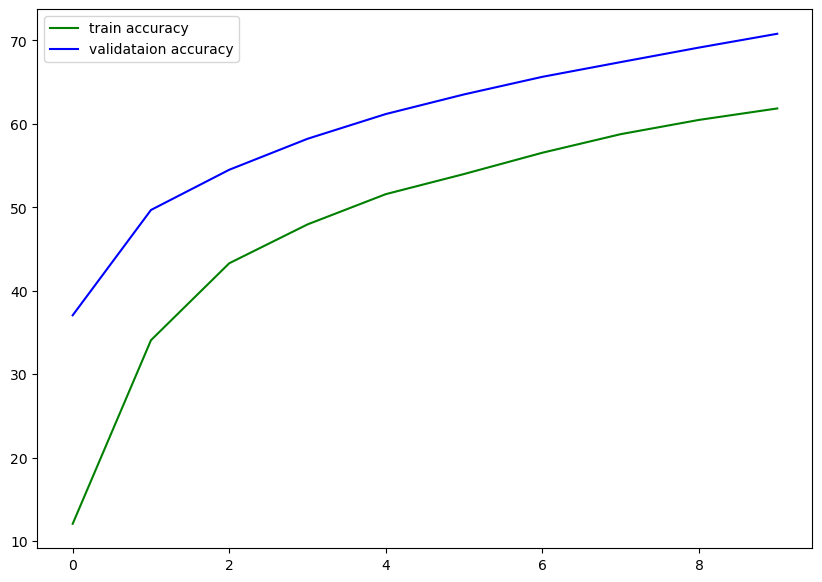

In [60]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

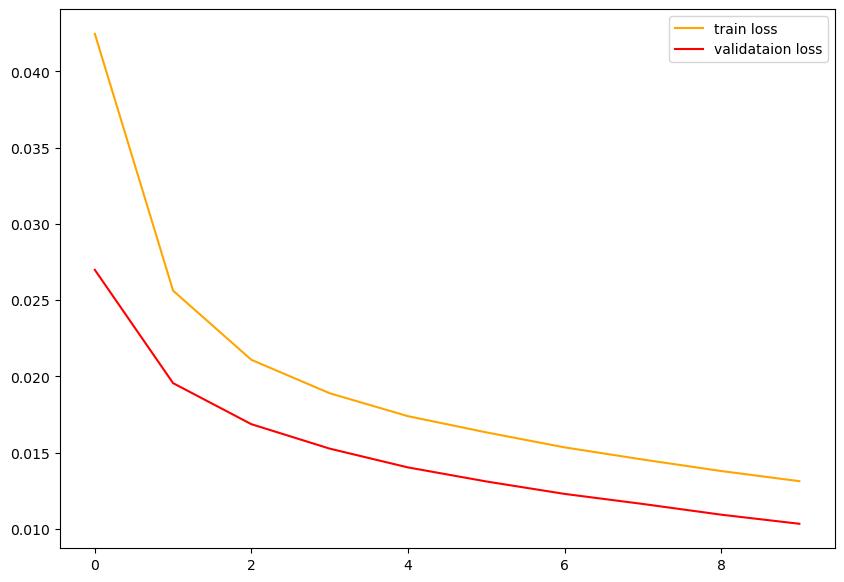

In [61]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [62]:
import numpy as np
import matplotlib.pyplot as plt

num_of_examples = 10 #only even numbers (please)
num_cols = 2
num_rows = int(num_of_examples/num_cols)

print("showing at least %s of the errors"%num_of_examples)

def imshow(img):
	img = img / 2 + 0.5 # unnormalize
	npimg = img.cpu().numpy()
	plt.imshow(np.transpose(npimg, (1, 2, 0)))#rearranges the dimensions of the image array from (C, H, W) (color channel, height, width) to (H, W, C)
	plt.axis('off')

wrong_images = []
wrong_preds = []
wrong_labels = []
#image list of the CIFAR-10 in text
cifar100_classes = [    "beaver",    "dolphin",    "otter",    "seal",    "whale",    "aquarium fish",    "flatfish",    "ray",    "shark",    "trout",    "orchids",    "poppies",    "roses",    "sunflowers",    "tulips",    "bottles",    "bowls",    "cans",    "cups",    "plates",    "apples",    "mushrooms",    "oranges",    "pears",    "sweet peppers",    "clock",    "computer keyboard",    "lamp",    "telephone",    "television",    "bed",    "chair",    "couch",    "table",    "wardrobe",    "bee",    "beetle",    "butterfly",    "caterpillar",    "cockroach",    "bear",    "leopard",    "lion",    "tiger",    "wolf",    "bridge",    "castle",    "house",    "road",    "skyscraper",    "cloud",    "forest",    "mountain",    "plain",    "sea",    "camel",    "cattle",    "chimpanzee",    "elephant",    "kangaroo",    "fox",    "porcupine",    "possum",    "raccoon",    "skunk",    "crab",    "lobster",    "snail",    "spider",    "worm",    "baby",    "boy",    "girl",    "man",    "woman",    "crocodile",    "dinosaur",    "lizard",    "snake",    "turtle",    "hamster",    "mouse",    "rabbit",    "shrew",    "squirrel",    "maple",    "oak",    "palm",    "pine",    "willow",    "bicycle",    "bus",    "motorcycle",    "pickup truck",    "train",    "lawn-mower",    "rocket",    "streetcar",    "tank",    "tractor"]
cnt = 0
with torch.no_grad():
	for data in testloader:
		inputs, labels = data
		inputs, labels = inputs.to(device), labels.to(device)
		outputs = vgg16model(inputs)
		_, predicted = torch.max(outputs.data, 1)
		cnt = cnt + 1
# Store the wrongly guessed images, predictions, and actual answers
for i, (p, l) in enumerate(zip(predicted, labels)):
	if p != l:
		wrong_images.append(inputs[i])
		wrong_preds.append(p.item())
		wrong_labels.append(l.item())


showing at least 10 of the errors


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

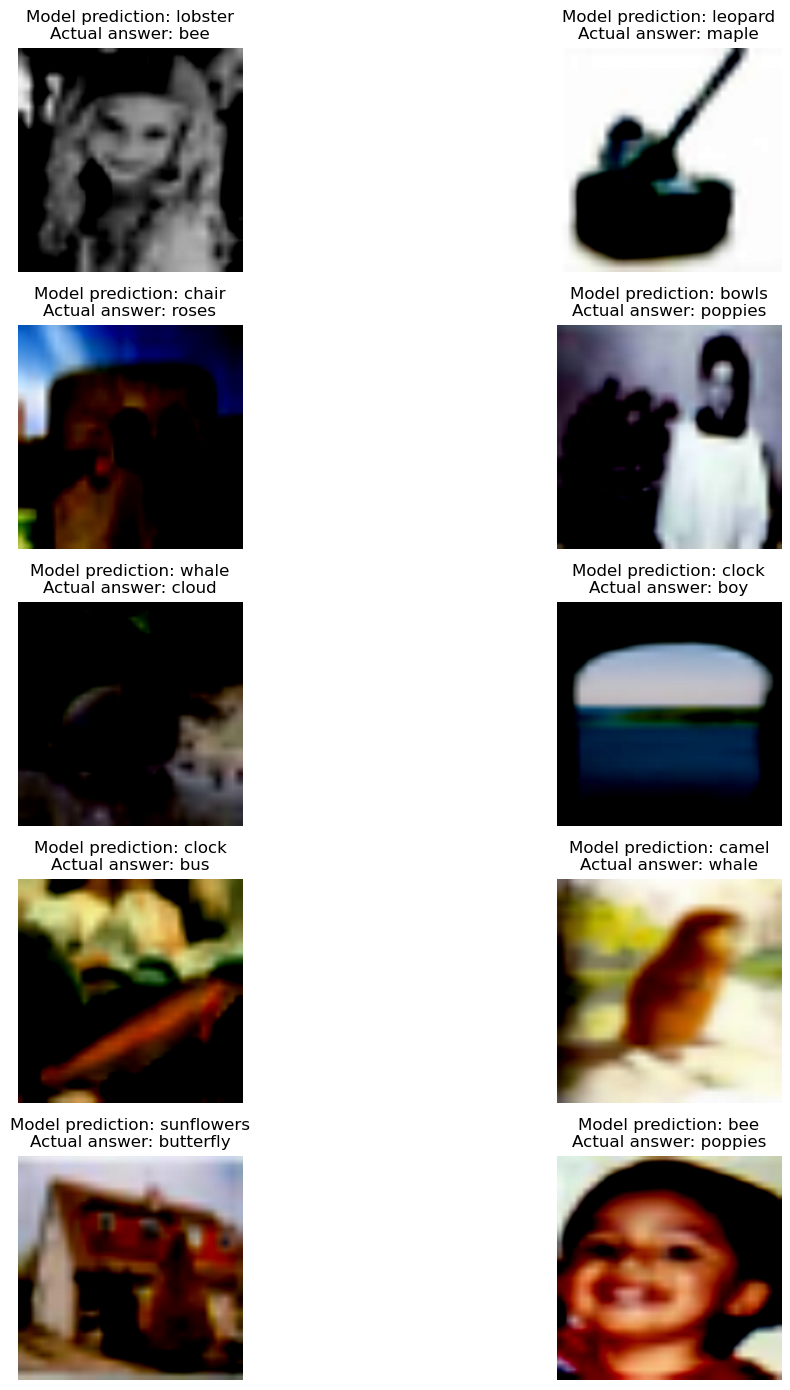

In [80]:
import random
fig, ax = plt.subplots(num_rows, num_cols, figsize=(14, 14))
ranlist = []
for i, (img, p, l) in enumerate(zip(wrong_images, wrong_preds, wrong_labels)):
    
    #preventing the same image

	num = random.randrange(0,len(wrong_images))
	while(1):
		if (num in ranlist):
			num = random.randrange(0,len(wrong_images))
		else:
			break
	ranlist.append(num)

	img , p , l = wrong_images[num], wrong_preds[num], wrong_labels[num]
	r = i // num_cols
	c = i % num_cols
	try:
		ax[r, c].imshow(np.transpose(torchvision.utils.make_grid(img).to('cpu').numpy(), (1, 2, 0)))
		ax[r, c].set_title("Model prediction: {}\nActual answer: {}".format(cifar100_classes[p], cifar100_classes[l]))
		ax[r, c].axis('off')
	except:
		break
	if i > num_of_examples: #print only 10
		break
plt.tight_layout()
plt.show()